# Surface velocities ACCESS

In [1]:
import glob
import dask.distributed as dsk
import xesmf as xe
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cartopy.feature as cft
import glob

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39025/status,
Dashboard: /proxy/39025/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36401,Workers: 0
Dashboard: /proxy/39025/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43727,Total threads: 1
Dashboard: /proxy/39565/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38885,


In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [9]:
# Time variant variables
def preprocess(ds):
    ds = ds[['u', 'v','salt']].isel(st_ocean=0).sel(yt_ocean=slice(None,-37)).sel(yu_ocean=slice(None,-37)) # Taking just the surface
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [10]:
# Time slicing
# Last 5 years only for anomaly maps
cont = cont.sel(time=slice('1915-01-01','1919-12-31')).mean(dim='time')
melt = melt.sel(time=slice('1915-01-01','1919-12-31')).mean(dim='time')

In [11]:
uo_C = cont['u']
vo_C = cont['v']
uo_M = melt['u']
vo_M = melt['v']

In [12]:
# Variable with xt_ocean and yt_ocean
salt_C = cont['salt']
salt_M = melt['salt']

# Merging to get all grid coordinates
cont_var = xr.merge([uo_C,vo_C,salt_C])
pert_var = xr.merge([uo_M,vo_M,salt_M])

cont_var

<xarray.Dataset> Size: 37MB
Dimensions:   (xu_ocean: 3600, yu_ocean: 846, xt_ocean: 3600, yt_ocean: 846)
Coordinates:
    st_ocean  float64 8B 0.5413
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 7kB -81.09 -81.05 -81.0 ... -37.18 -37.1 -37.02
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -37.14 -37.06
Data variables:
    u         (yu_ocean, xu_ocean) float32 12MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    v         (yu_ocean, xu_ocean) float32 12MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    salt      (yt_ocean, xt_ocean) float32 12MB dask.array<chunksize=(270, 360), meta=np.ndarray>

In [13]:
path_to_ocean_static_M = Path('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/output040/ocean/ocean_grid.nc')
ocean_static_M = xr.open_dataset(path_to_ocean_static_M)

path_to_ocean_static_C = Path('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output000/ocean/ocean_grid.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

In [14]:
ocean_static_M = ocean_static_M.sel(xu_ocean = pert_var['xu_ocean'], xt_ocean = pert_var['xt_ocean'], yu_ocean = pert_var['yu_ocean'], yt_ocean = pert_var['yt_ocean'])

grid_M = xgcm.Grid(ocean_static_M, coords = {'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                                     'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'}},
                                   periodic = ['X'])

ocean_static_C = ocean_static_C.sel(xu_ocean = cont_var['xu_ocean'], xt_ocean = cont_var['xt_ocean'], yu_ocean = cont_var['yu_ocean'], yt_ocean = cont_var['yt_ocean'])

grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                                     'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'}},
                                   periodic = ['X'])

In [15]:
u_int_C = grid_C.interp(cont_var['u'], 'X')
u_int_C = grid_C.interp(u_int_C, 'Y')

v_int_C = grid_C.interp(cont_var['v'], 'X')
v_int_C = grid_C.interp(v_int_C, 'Y')

u_int_M = grid_M.interp(pert_var['u'], 'X')
u_int_M = grid_M.interp(u_int_M, 'Y')

v_int_M = grid_M.interp(pert_var['v'], 'X')
v_int_M = grid_M.interp(v_int_M, 'Y')

In [16]:
u_int_C

<xarray.DataArray 'u' (yt_ocean: 846, xt_ocean: 3600)> Size: 12MB
dask.array<transpose, shape=(846, 3600), dtype=float32, chunksize=(270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -37.14 -37.06

In [17]:
v_int_C

<xarray.DataArray 'v' (yt_ocean: 846, xt_ocean: 3600)> Size: 12MB
dask.array<transpose, shape=(846, 3600), dtype=float32, chunksize=(270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -37.14 -37.06

In [18]:
u_int_M

<xarray.DataArray 'u' (yt_ocean: 846, xt_ocean: 3600)> Size: 12MB
dask.array<transpose, shape=(846, 3600), dtype=float32, chunksize=(270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -37.14 -37.06

In [19]:
v_int_M

<xarray.DataArray 'v' (yt_ocean: 846, xt_ocean: 3600)> Size: 12MB
dask.array<transpose, shape=(846, 3600), dtype=float32, chunksize=(270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -37.14 -37.06

In [20]:
abs_C = np.sqrt(u_int_C**2 + v_int_C**2)
abs_M = np.sqrt(u_int_M**2 + v_int_M**2)

In [21]:
abs_anom = abs_M - abs_C
abs_anom

<xarray.DataArray (yt_ocean: 846, xt_ocean: 3600)> Size: 12MB
dask.array<sub, shape=(846, 3600), dtype=float32, chunksize=(270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -37.14 -37.06

In [22]:
abs_anom = abs_anom.load()

In [23]:
abs_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_prescribed_ACCESS.nc')

## Plotting

In [26]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

In [29]:
# Create a mask: True where depth is greater (deeper) than 3000m (or less if bathy is negative)
mask_3000m = depth > 4000  # or bathy < -3000 depending on bathy convention (usually negative)

# Mask your data array (abs_anom) where bathy is deeper than 3000m
import numpy as np
abs_anom_masked = abs_anom.where(~mask_3000m).fillna(0)  # keep data only shallower or equal to 3000m

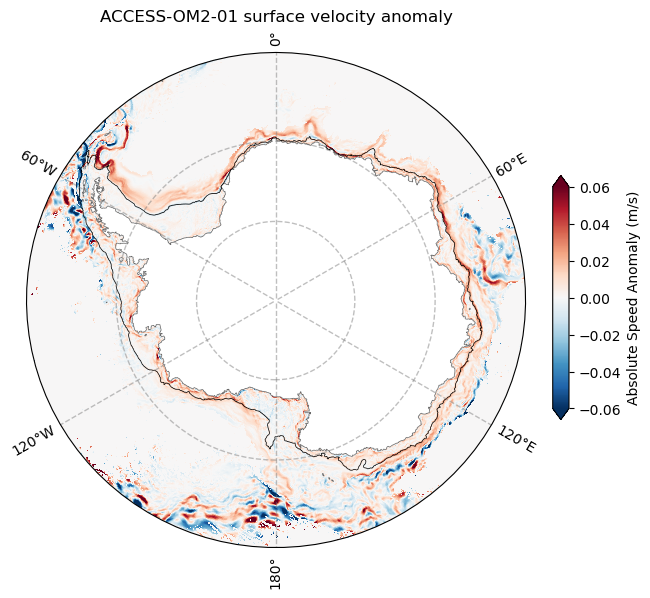

In [31]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos
                   (theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
abs_anom_masked.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=plt.get_cmap('RdBu').reversed(), #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Absolute Speed Anomaly (m/s)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2-01 surface velocity anomaly");